In [1]:
import os
import os.path as path
import re
from enum import Enum
from functools import total_ordering

import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import matplotlib.patheffects as PathEffects
import pandas as pd
import seaborn as sns

import ptitprince as pt

from tqdm.notebook import tqdm
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=False)


import statsmodels.api as sm
import statsmodels.formula.api as smf

mpl.style.use('seaborn')

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
subjPattern = re.compile(r"^\d+$")
trialPattern = re.compile(r"^(?P<block>\d\d)_(?P<trial>\d\d)(?P<data>\w+)\.tsv$")

ID01 = "00"
ID02 = "01"
ID03 = "02"
IDENTS = [ID01, ID02, ID03]

subjects = sorted([d for d in os.listdir() if subjPattern.match(d)])
print(', '.join(subjects))

def load_subject(subjId):
    datadict = {
        ID01 : {ID01 : [], ID02 : [], ID03 : []}, # block 1
        ID02 : {ID01 : [], ID02 : [], ID03 : []}, # block 2
        ID03 : {ID01 : [], ID02 : [], ID03 : []} # block 3
    }
    files = os.listdir(subjId)
    for file in files:
        match = trialPattern.match(file)
        if not match:
            print("Error!", path.join(subjId, file))
            continue
        block_id = match.groups()[0]
        trial_id = match.groups()[1]
        datadict[block_id][trial_id].append(file)
        
    return datadict

def load_csv(filepath:str=None, subject:str=None, file:str=None) -> pd.DataFrame:
    if filepath is None:
        filepath = path.join(subject, file)
    df = pd.read_csv(filepath, sep='\t', usecols=lambda c: not c.startswith('Unnamed:'))
    return df

@total_ordering
class Boxes(Enum):
    NoBox  = 0
    SmallL = 10
    SmallC = 11
    SmallR = 12
    LargLC = 20
    LargCR = 21
    LargLR = 22

    def __lt__(self, other):
        if self.__class__ is other.__class__:
            return self.value < other.value
        return NotImplemented

    def __int__(self):
        return self.value

@total_ordering
class Collisions(Enum):
    no = 0
    bump = 1
    strafe = 2
    crash = 5

    def __lt__(self, other):
        if self.__class__ is other.__class__:
            return self.value < other.value
        return NotImplemented

001, 002, 003, 004, 005, 006, 007, 008, 009, 010, 011, 012, 013, 014, 015, 016, 017, 018, 019, 020, 021, 022, 023


In [3]:
@total_ordering
class Boxes(Enum):
    NoBox  = 0
    SmallL = 10
    SmallC = 11
    SmallR = 12
    LargLC = 20
    LargCR = 21
    LargLR = 22

    def __lt__(self, other):
        if self.__class__ is other.__class__:
            return self.value < other.value
        return NotImplemented

    def __int__(self):
        return self.value

# w x d x h
smBox = [.6, .3, .9]
lgBox = [.95, .3, 1.8]
pRadius = .225
hwWidth = 2.85
segmentLength = 2
hwStartX = [0, 4, 8]

hallway1 = [
            Boxes.SmallC,
            Boxes.SmallC,
            Boxes.LargCR,
            Boxes.SmallL,
            Boxes.SmallR,
            Boxes.SmallC,
            Boxes.LargLR,
            Boxes.SmallL,
            Boxes.SmallL,
            Boxes.LargLC, # transition to 5
            Boxes.SmallC,
            Boxes.SmallR,
            Boxes.LargLR,
            Boxes.SmallC,
            Boxes.SmallL,
            Boxes.SmallR,
            Boxes.LargCR,
            Boxes.SmallC,
            Boxes.SmallC
]

hallway2 = [
            Boxes.SmallL,
            Boxes.SmallC,
            Boxes.LargCR,
            Boxes.SmallL,
            Boxes.SmallL,
            Boxes.SmallR,
            Boxes.LargLC,
            Boxes.SmallR,
            Boxes.SmallL,
            Boxes.LargCR, # transition to 3
            Boxes.SmallR,
            Boxes.SmallL,
            Boxes.LargLR,
            Boxes.SmallC,
            Boxes.SmallL,
            Boxes.SmallC,
            Boxes.LargCR,
            Boxes.SmallC,
            Boxes.SmallL
]

hallway3 = [
            Boxes.SmallL,
            Boxes.SmallC,
            Boxes.LargCR,
            Boxes.SmallR,
            Boxes.SmallL,
            Boxes.SmallC,
            Boxes.LargLR,
            Boxes.SmallL,
            Boxes.SmallC,
            Boxes.LargLC, # transition to 7
            Boxes.SmallR,
            Boxes.SmallR,
            Boxes.LargLC,
            Boxes.SmallC,
            Boxes.SmallR,
            Boxes.SmallL,
            Boxes.LargCR,
            Boxes.SmallC,
            Boxes.SmallL
]

hallways = [hallway1, hallway2, hallway3]


In [4]:
def load_subject(subjId):
    datadict = {
        ID01 : {ID01 : [], ID02 : [], ID03 : []}, # block 1
        ID02 : {ID01 : [], ID02 : [], ID03 : []}, # block 2
        ID03 : {ID01 : [], ID02 : [], ID03 : []} # block 3
    }
    files = os.listdir(subjId)
    for file in files:
        match = trialPattern.match(file)
        if not match:
            print("Error!", path.join(subjId, file))
            continue
        block_id = match.groups()[0]
        trial_id = match.groups()[1]
        datadict[block_id][trial_id].append(file)
        
    return datadict

def load_csv(filepath:str=None, subject:str=None, file:str=None) -> pd.DataFrame:
    if filepath is None:
        filepath = path.join(subject, file)
    df = pd.read_csv(filepath, sep='\t', usecols=lambda c: not c.startswith('Unnamed:'))
    return df


def vec2coord(s:pd.Series, keep=[0,1,2,3]):
    """Convert the stored vector in str: '(x,y,z)' to df with columns x&y"""
    vecs = s.apply(lambda v: np.array(v[1:-1].split(', ')).astype(float))
    p = pd.DataFrame(np.stack(vecs.values))
    if len(keep) > len(p.columns):
        keep = range(len(p.columns))
    labels = np.array(['x', 'y', 'z', 'w'])
    p = p[p.columns[keep]]
    p.columns = labels[:len(keep)]
    p.index = s.index
    return p

def pos2path(s:pd.Series, hallwayId:int):
    # convert text vector to 2d vector array
    # [2,0] "rotates" vector, hallways are drawn left -> right
    # so x (left, right) becomes y, and z (forward) becomes x
    p = vec2coord(s, [2,0])
    # 0-center path by subtracting hallway offset (id * 4)
    # in Unity right is positive, left is negative
    # we must negate to get correct orientation
    # then add half-width to put correct starting position
    p.y = -1 * (p.y - hallwayId * 4) + hwWidth / 2
    # add segment-length to account for first empty room behind start
    p.x += segmentLength
    return p

def round_to_multiple(number, multiple):
    return multiple * round(number / multiple)

In [5]:
def get_filtered_eye_position(s:pd.Series):
    eyePos = vec2coord(s, [0,1])
    eyePos = eyePos[(eyePos.x <= 1) & (eyePos.x >= 0)]
    eyePos = eyePos[(eyePos.y <= 1) & (eyePos.y >= 0)]
    return eyePos

def get_eye_distance_travelled(s:pd.Series):
    eyePos = get_filtered_eye_position(s)
    delta = eyePos.diff()
    return np.sqrt(delta.x ** 2 + delta.y ** 2).sum()
    
def get_eye_average_dist(s_left:pd.Series, s_right:pd.Series):
    distL = get_eye_distance_travelled(s_left)
    distR = get_eye_distance_travelled(s_right)
    return (distL + distR) / 2

def zscore_each_column(df):
    for c in df.columns:
        df[c] = ( df[c] - df[c].mean() ) / df[c].std()
    return df

In [6]:
def create_eyepos_df():
    all_subjects = []
    for subj in tqdm(subjects):
        filemapping = load_subject(subj)
        blocks_dfs = []
        for block, trialfiles in filemapping.items():
            trial_dfs = []
            block_keys = []
            for trial, files in trialfiles.items():
                files = sorted(files)
                condition = load_csv(subject=subj, file=files[-1]).loc[0, 'GazeCondition']
                cond_name = "G.Ignored" if condition == "GazeIgnored" else "G.Locked" if condition == "SimulationFixedToGaze" else "G.Assisted"
                
                dfEyeL = load_csv(subject=subj, file=files[3])
                dfEyeL.set_index("TimeStamp", inplace=True)
                dfEyeR = load_csv(subject=subj, file=files[4])
                dfEyeR.set_index("TimeStamp", inplace=True)

                shared_index = dfEyeR.index.intersection(dfEyeL.index)
                dfEyeL = dfEyeL.loc[shared_index]
                dfEyeR = dfEyeR.loc[shared_index]

                sensorPosL = get_filtered_eye_position(dfEyeL['PosInSensor'])
                # zscore_each_column(sensorPosL)
                # sensorDistL = np.sqrt(((sensorPosL.shift() - sensorPosL) ** 2).sum(axis=1))

                sensorPosR = get_filtered_eye_position(dfEyeR['PosInSensor'])
                # zscore_each_column(sensorPosR)
                # sensorDistR = np.sqrt(((sensorPosR.shift() - sensorPosR) ** 2).sum(axis=1))

                gazeOriginPosL = vec2coord(dfEyeL['GazeOriginInEye'])
                # zscore_each_column(gazeOriginPosL)
                # gazeOriginDistL = np.sqrt(((gazeOriginPosL.shift() - gazeOriginPosL) ** 2).sum(axis=1))

                gazeOriginPosR = vec2coord(dfEyeR['GazeOriginInEye'])
                # zscore_each_column(gazeOriginPosR)
                # gazeOriginDistR = np.sqrt(((gazeOriginPosR.shift() - gazeOriginPosR) ** 2).sum(axis=1))
                
                trial_df = pd.concat([
                    pd.concat([sensorPosL, gazeOriginPosL], axis=1, keys=["SensorPos", "GazeOrigin"]),
                    pd.concat([sensorPosR, gazeOriginPosR], axis=1, keys=["SensorPos", "GazeOrigin"])
                ], axis=1, keys=["LeftEye", "RightEye"])

                trial_dfs.append(trial_df)
                block_keys.append(cond_name)
            
            # blocks_dfs.append(zscore_each_column( pd.concat(trial_dfs, axis=0, keys=block_keys, names=['Condition'] + trial_dfs[0].index.names) ))
            blocks_dfs.append( pd.concat(trial_dfs, axis=0, keys=block_keys, names=['Condition'] + trial_dfs[0].index.names) )

        # concatenate all blocks
        df = pd.concat(blocks_dfs, axis=0, keys=IDENTS, names=['Block'] + blocks_dfs[0].index.names)
        all_subjects.append(df)    

    return pd.concat(all_subjects, axis=0, keys=subjects, names=['Subject'] + all_subjects[0].index.names)

In [7]:
try:
    # raise Exception
    df = pd.read_hdf('data.h5', key='eyepos')
except:
    df = create_eyepos_df()
    df.to_hdf('data.h5', key='eyepos', complevel=7)

bckp = df.copy()
df.head(15)

LeftEye                      \
                                           SensorPos          GazeOrigin   
                                                   x        y          x   
Subject Block Condition TimeStamp                                          
001     00    G.Ignored 637933112670380485   0.55981  0.40749   32.76842   
                        637933112671847774   0.56677  0.41317   32.74544   
                        637933112671897791   0.56677  0.41317   32.74544   
                        637933112671947781   0.56543  0.41071   32.77185   
                        637933112672007781   0.56543  0.41071   32.77185   
                        637933112672047787   0.56543  0.41071   32.77185   
                        637933112672107787   0.56543  0.41071   32.77185   
                        637933112672167779   0.56445  0.40686   32.79816   
                        637933112672227787   0.56445  0.40686   32.79816   
                        637933112672277012   0.56360  0.40270   32.81476   
                        637933112672327032   0.56360  0.40270   32.81476   
                        637933112672387012   0.56360  0.40270   32.81476   
                        637933112672447020   0.56389  0.39975   32.82219   
                        637933112672497023   0.56389  0.39975   32.82219   
                        637933112672537046   0.56389  0.39975   32.82219   

                                                               RightEye  \
                                                              SensorPos   
                                                  y         z         x   
Subject Block Condition TimeStamp                                         
001     00    G.Ignored 637933112670380485  6.53841 -28.28435   0.58072   
                        637933112671847774  6.40868 -28.36081   0.59750   
                        637933112671897791  6.40868 -28.36081   0.59750   
                        637933112671947781  6.43045 -28.35683   0.59787   
                        637933112672007781  6.43045 -28.35683   0.59787   
                        637933112672047787  6.43045 -28.35683   0.59787   
                        637933112672107787  6.43045 -28.35683   0.59787   
                        637933112672167779  6.47261 -28.34888   0.59896   
                        637933112672227787  6.47261 -28.34888   0.59896   
                        637933112672277012  6.54190 -28.33246   0.59997   
                        637933112672327032  6.54190 -28.33246   0.59997   
                        637933112672387012  6.54190 -28.33246   0.59997   
                        637933112672447020  6.59267 -28.32028   0.60106   
                        637933112672497023  6.59267 -28.32028   0.60106   
                        637933112672537046  6.59267 -28.32028   0.60106   

                                                                         \
                                                    GazeOrigin            
                                                  y          x        y   
Subject Block Condition TimeStamp                                         
001     00    G.Ignored 637933112670380485  0.60600  -34.22554  2.42250   
                        637933112671847774  0.59920  -34.43965  2.30634   
                        637933112671897791  0.59920  -34.43965  2.30634   
                        637933112671947781  0.59885  -34.44041  2.31096   
                        637933112672007781  0.59885  -34.44041  2.31096   
                        637933112672047787  0.59885  -34.44041  2.31096   
                        637933112672107787  0.59885  -34.44041  2.31096   
                        637933112672167779  0.59517  -34.46809  2.35896   
                        637933112672227787  0.59517  -34.46809  2.35896   
                        637933112672277012  0.59364  -34.45425  2.40837   
                        637933112672327032  0.59364  -34.45425  2.40837   
                        637933112672387012  0.593

In [13]:
idx = pd.IndexSlice
sensorspace = df.loc[:, idx[:, 'SensorPos', :]]
sensorspace.columns = pd.MultiIndex.from_product([['L', 'R'],['x','y']])
sensorspace.head(5)

L                 R         
                                                  x        y        x        y
Subject Block Condition TimeStamp                                             
001     00    G.Ignored 637933112670380485  0.55981  0.40749  0.58072  0.60600
                        637933112671847774  0.56677  0.41317  0.59750  0.59920
                        637933112671897791  0.56677  0.41317  0.59750  0.59920
                        637933112671947781  0.56543  0.41071  0.59787  0.59885
                        637933112672007781  0.56543  0.41071  0.59787  0.59885

In [14]:
sensorspace.describe()

L                           R              
                  x             y             x             y
count  1.465350e+06  1.465350e+06  1.459288e+06  1.459288e+06
mean   5.073951e-01  4.593879e-01  4.909261e-01  5.835939e-01
std    7.275835e-02  1.255776e-01  7.990641e-02  1.221705e-01
min    3.365000e-02  6.856000e-02  7.960000e-02  1.133300e-01
25%    4.593600e-01  3.626600e-01  4.346500e-01  4.963400e-01
50%    5.024700e-01  4.625300e-01  4.861500e-01  5.915000e-01
75%    5.462400e-01  5.464800e-01  5.415200e-01  6.632800e-01
max    9.349200e-01  9.430500e-01  9.537700e-01  9.636200e-01

In [15]:
T_smooth = .12
T_fast = 0.0001
thrsh = 0.25

def smooth_eye(eyeL, eyeR, desc=None):

    smoothed_pos = np.zeros((2, eyeL.shape[0], eyeL.shape[1]))

    T_return = [-1, -1]
    return_speed = [-1, -1]

    for lb in range(len(eyeL) - 8):
        ub = lb + 8
        for idx, eye in enumerate([eyeL, eyeR]):
            window = eye[['x', 'y']].iloc[lb:ub]
            h = eye.iloc[ub].h

            if return_speed[idx] > 0:
                T_return[idx] += return_speed[idx]
                return_speed[idx] += 1 / (10 * h)
                if T_return[idx] > T_smooth:
                    T_return[idx] = -1
                    return_speed[idx] = -1

            elif np.sum((np.abs(window.iloc[:4].mean() - window.iloc[4:].mean()) ** 2)) > (thrsh ** 2):
                T_return[idx] = T_fast
                return_speed[idx] = 1 / ( 10 * h )

            T = T_smooth if T_return[idx] < 0 else T_return[idx]
            alpha = T / h

            pos = window.iloc[-1]
            prev_smooth = smoothed_pos[idx, ub,:2]
            prev_smooth = prev_smooth if prev_smooth.sum() > 0 else pos
            smoothed_pos[idx, ub,:2] = (pos + alpha * pos) / ( 1 + alpha )
            smoothed_pos[idx, ub, 2] = h

    df_L = pd.DataFrame(smoothed_pos[0], columns=['x', 'y', 'h'], index=eyeL.index)
    df_R = pd.DataFrame(smoothed_pos[1], columns=['x', 'y', 'h'], index=eyeL.index)
    df = pd.concat([df_L, df_R], keys=['Left', 'Right'], axis=1)
    return df.iloc[8:]


def smooth(trial_df:pd.DataFrame) -> pd.DataFrame:
    df = trial_df.sort_index().reset_index()
    timestep = df['TimeStamp'].diff() / 1e4
    timestep.iloc[0] = 0
    df['timestep'] = timestep
    df = df.loc[(df['timestep'] < (df['timestep'].mean() * 4)) & (df['timestep'] > 0)]
    df = df[df.columns[2:]]
    df = df.dropna()
    df =  df.set_index('TimeStamp')

    df.columns = ['LX', 'LY', 'RX', 'RY', 'timestep']
    desc = f"{trial_df.reset_index().Block.iloc[0]} :: {trial_df.reset_index().Condition.iloc[0]}"
    return smooth_eye(
            df[['LX', 'LY', 'timestep']].rename(columns={'LX':'x', 'LY':'y', 'timestep':'h'}), 
            df[['RX', 'RY', 'timestep']].rename(columns={'RX':'x', 'RY':'y', 'timestep':'h'}),
            desc )

In [16]:
try:
    # raise Exception
    smoothed_eye_pos = pd.read_hdf('data.h5', key='eyepos_smoothed')
except:
    allsubj = [sensorspace.loc[subj].groupby([ 'Block', 'Condition' ]).parallel_apply(smooth) for subj in tqdm(subjects)]
    smoothed_eye_pos = pd.concat(allsubj, axis=0, keys=subjects, names=['Subject'] + allsubj[0].index.names)
    smoothed_eye_pos.to_hdf('data.h5', key='eyepos_smoothed', complevel=7)

smoothed_eye_pos.head(5)

Left                    \
                                                   x        y        h   
Subject Block Condition  TimeStamp                                       
001     00    G.Assisted 637933116583809853  0.51234  0.29434  15.0013   
                         637933116583979846  0.49047  0.29327  16.9993   
                         637933116584139855  0.47005  0.30150  16.0009   
                         637933116584279869  0.45573  0.31507  14.0014   
                         637933116584449988  0.44688  0.31922  17.0119   

                                               Right                    
                                                   x        y        h  
Subject Block Condition  TimeStamp                                      
001     00    G.Assisted 637933116583809853  0.58304  0.50582  15.0013  
                         637933116583979846  0.56083  0.50341  16.9993  
                         637933116584139855  0.54239  0.50667  16.0009  
                         637933116584279869  0.52068  0.51355  14.0014  
                         637933116584449988  0.50903  0.51736  17.0119

/tmp/ipykernel_472/143062618.py:23: PerformanceWarning: indexing past lexsort depth may impact performance.
  l = df.loc['004', '02', cond, :][('LeftEye', 'SensorPos')].dropna().iloc[::every_n]
/tmp/ipykernel_472/143062618.py:24: PerformanceWarning: indexing past lexsort depth may impact performance.
  r = df.loc['004', '02', cond, :][('RightEye', 'SensorPos')].dropna().iloc[::every_n]
/tmp/ipykernel_472/143062618.py:23: PerformanceWarning: indexing past lexsort depth may impact performance.
  l = df.loc['004', '02', cond, :][('LeftEye', 'SensorPos')].dropna().iloc[::every_n]
/tmp/ipykernel_472/143062618.py:24: PerformanceWarning: indexing past lexsort depth may impact performance.
  r = df.loc['004', '02', cond, :][('RightEye', 'SensorPos')].dropna().iloc[::every_n]
/tmp/ipykernel_472/143062618.py:23: PerformanceWarning: indexing past lexsort depth may impact performance.
  l = df.loc['004', '02', cond, :][('LeftEye', 'SensorPos')].dropna().iloc[::every_n]
/tmp/ipykernel_472/143062618

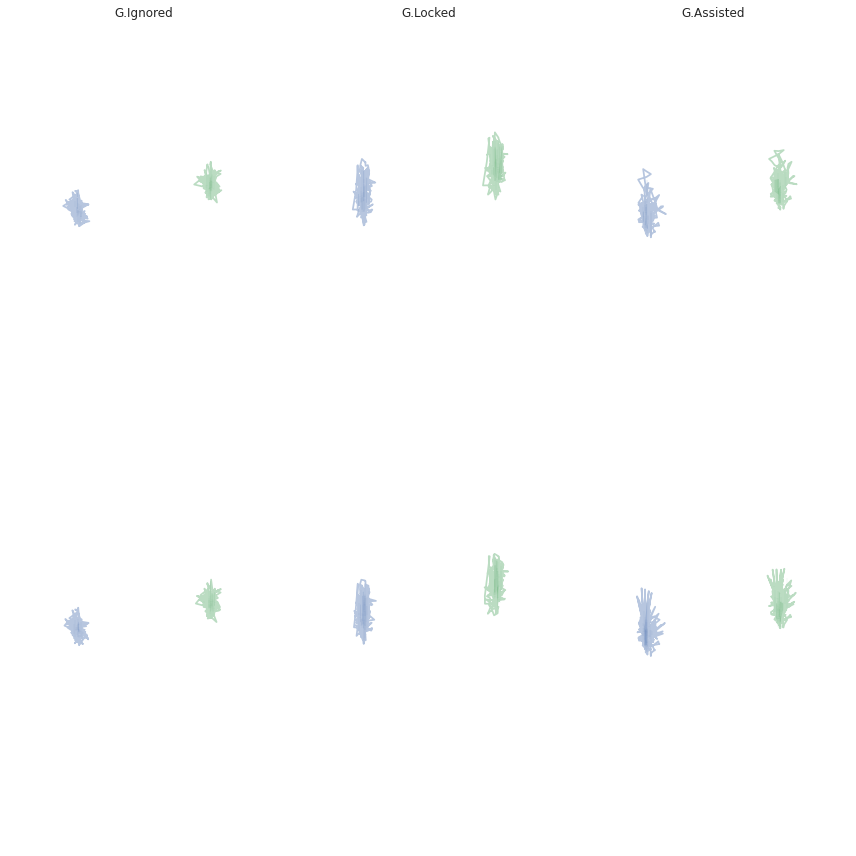

In [41]:
fig, axs = plt.subplots(2,3, figsize=(12,12))
for ax in axs.flatten():
    ax.set_ylim((0,1))
    ax.set_xlim((0,2.05))
    # ax.set(aspect='equal')
    ax.axis('off')

every_n = 5
kwargs = {
    'sort': False,
    'alpha': .4
}
for idx, cond in enumerate(sensorspace.index.get_level_values(2).unique()):
    axs[0,idx].set_title(cond)
    # smoothed
    l = smoothed_eye_pos.loc['004','02', cond, :]['Left'].iloc[::every_n]
    r = smoothed_eye_pos.loc['004','02', cond, :]['Right'].iloc[::every_n]
    r.x += 1.05
    sns.lineplot( data=l, x='x', y='y', ax=axs[0,idx], **kwargs)
    sns.lineplot( data=r, x='x', y='y', ax=axs[0,idx], **kwargs)

    # unsmoothed
    l = df.loc['004', '02', cond, :][('LeftEye', 'SensorPos')].dropna().iloc[::every_n]
    r = df.loc['004', '02', cond, :][('RightEye', 'SensorPos')].dropna().iloc[::every_n]
    r.x += 1.05
    sns.lineplot( data=l, x='x', y='y', ax=axs[1,idx], **kwargs)
    sns.lineplot( data=r, x='x', y='y', ax=axs[1,idx], **kwargs)

plt.tight_layout()

In [71]:
def adjust_bonferroni_holm(contrasts):
    N = contrasts.pvalue.shape[0]
    c = np.arange(1, N+1, 1)
    i = np.argsort(contrasts.pvalue)[::-1]
    
    return np.clip(contrasts.pvalue * c[i], 0, 1)

modeldata = (sensorspace.diff() ** 2).groupby(['Subject','Block','Condition']).sum().mean(axis=1).to_frame().loc[:,ID02:ID03,:].reset_index()
modeldata.columns = list(modeldata.columns[:-1]) + ['Dist']

md = smf.mixedlm("Dist ~ -1 + Condition + Block", modeldata, groups=modeldata["Subject"])
mdf = md.fit()
print(mdf.summary())
# sm.qqplot(mdf.resid)
contrasts = mdf.t_test(np.array([[1,-1,0,0], [0,1,-1,0], [1,0,-1,0]]), use_t=True)
contrasts.pvalue = adjust_bonferroni_holm(contrasts)
print(contrasts.summary())

            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   Dist     
No. Observations:    138       Method:               REML     
No. Groups:          23        Scale:                12.7476  
Min. group size:     6         Log-Likelihood:       -370.7791
Max. group size:     6         Converged:            Yes      
Mean group size:     6.0                                      
--------------------------------------------------------------
                      Coef. Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------------
Condition[G.Assisted] 1.325    0.628 2.111 0.035  0.095  2.556
Condition[G.Ignored]  2.367    0.628 3.772 0.000  1.137  3.598
Condition[G.Locked]   2.113    0.628 3.366 0.001  0.883  3.343
Block[T.02]           0.730    0.608 1.201 0.230 -0.462  1.921
Group Var             0.564    0.248                          

                             Test for Constraints                  

In [ ]:
filter_dat = sensorspace - sensorspace.groupby(['Subject', 'Block', 'Condition']).mean().dropna()
lx = filter_dat[('L','x')]
ly = filter_dat[('L','y')]
rx = filter_dat[('R','x')]
ry = filter_dat[('R','y')]
data = pd.concat([(lx + rx) / 2, (ly + ry) / 2], keys=['x','y'], axis=1)
exp = data.loc['004', '02']

In [169]:
exp.loc['G.Locked'].

AttributeError: 'Int64Index' object has no attribute 'diff'

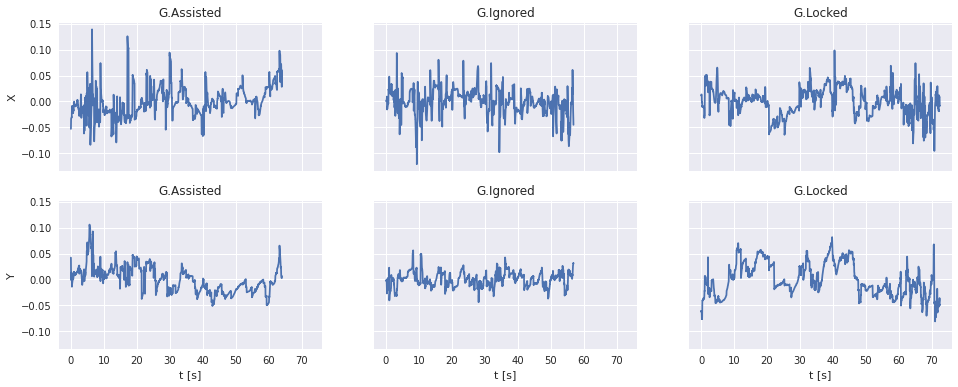

In [157]:
from scipy import fftpack
fig, axs = plt.subplots(2,3, figsize=(16,6), sharex=True, sharey=True)
for idx, cond in enumerate(exp.index.get_level_values(0).unique()):
    ax = axs[0, idx]
    if idx == 0:
        ax.set_ylabel('X')
    ax.set_title(cond)
    dat = exp.loc[cond].sort_index().dropna()
    time = pd.Series(dat.index.get_level_values(0)) / 1e7
    time -= time.iloc[0]

    ax.plot(time, dat.x.values)

    ax = axs[1, idx]
    if idx == 0:
        ax.set_ylabel('Y')
    ax.set_title(cond)
    ax.set_xlabel('t [s]')

    ax.plot(time, dat.y.values)

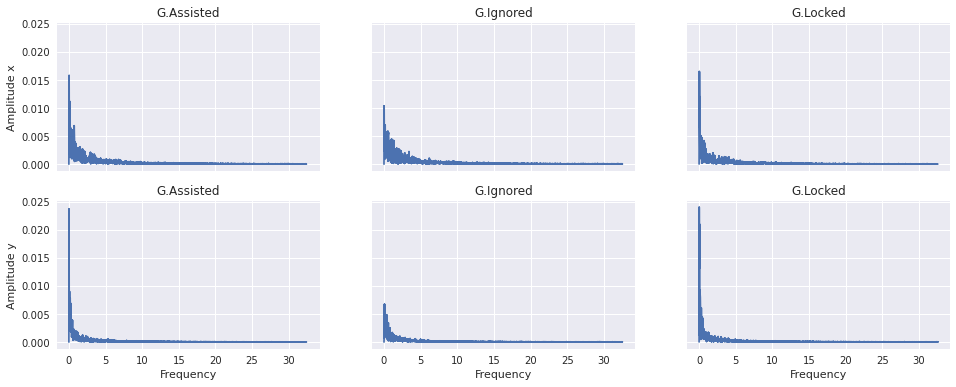

In [156]:
from scipy import fftpack
fig, axs = plt.subplots(2,3, figsize=(16,6), sharex=True, sharey=True)
for idx, cond in enumerate(exp.index.get_level_values(0).unique()):
    ax = axs[0, idx]
    if idx == 0:
        ax.set_ylabel('Amplitude x')
    ax.set_title(cond)
    dat = exp.loc[cond].sort_index().dropna()
    timestep = (pd.Series(dat.index.get_level_values(0)).diff() / 1e7).mean()

    fft = fftpack.fft(dat.x.values)
    amps = 2 / len(dat) * np.abs(fft)
    freqs = np.abs(fftpack.fftfreq(len(dat), timestep))

    ax.plot(freqs, amps)

    ax = axs[1, idx]
    if idx == 0:
        ax.set_ylabel('Amplitude y')
    ax.set_title(cond)
    ax.set_xlabel('Frequency')

    fft = fftpack.fft(dat.y.values)
    amps = 2 / len(dat) * np.abs(fft)
    freqs = np.abs(fftpack.fftfreq(len(dat), timestep))

    ax.plot(freqs, amps)

In [8]:
eyes = list(df.columns.get_level_values(0).unique())
types = list(df.columns.get_level_values(1).unique())
for eye in eyes:
    for typ in types:
        part = df[(eye, typ)]
        df[(eye, typ+'Dist', '')] = (( part.shift() - part )**2).sum(axis=1)

df = df[df.columns.sort_values()]
df

ValueError: No axis named 1 for object type Series

<AxesSubplot:xlabel='Condition', ylabel='0'>

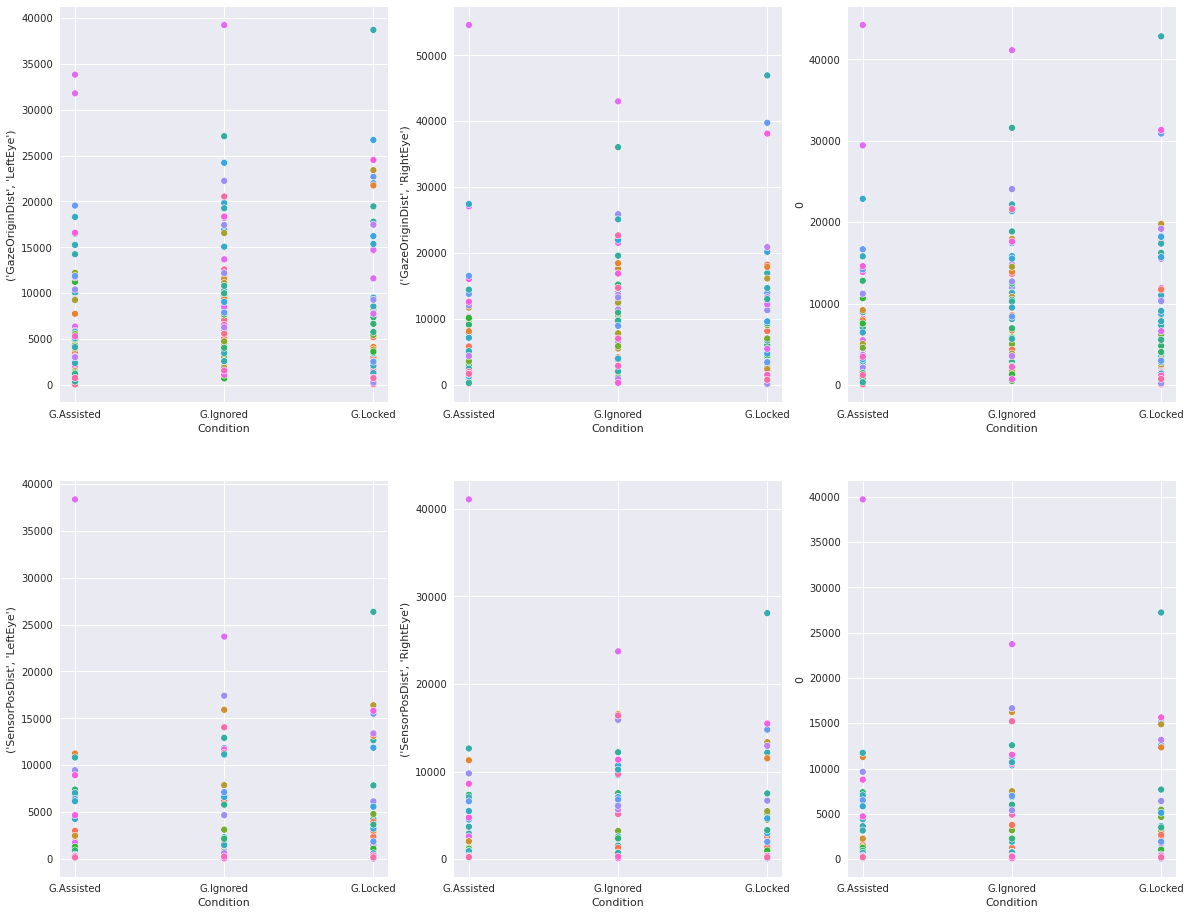

In [11]:
distances = df[[c for c in df.columns if 'Dist' in c[1]]]
idx = distances.columns#.groupby(['Subject', 'Block', 'Condition']).sum()
distances.columns = idx.droplevel(2).swaplevel(0,1)
distances = distances[distances.columns.sort_values()]
data = distances.groupby(['Subject', 'Block', 'Condition']).sum().swaplevel(0,2).sort_index()

fig, ax = plt.subplots(2,3, figsize=(20,16))
# # sns.lineplot(data=data, hue='Condition')
# sns.barplot(data=data, x='Condition', y='GazeOriginDist')
sns.scatterplot(data=data[('GazeOriginDist', 'LeftEye')].to_frame(), x='Condition', y=('GazeOriginDist','LeftEye'), hue='Subject', legend=[], ax=ax[0,0])
sns.scatterplot(data=data[('GazeOriginDist', 'RightEye')].to_frame(), x='Condition', y=('GazeOriginDist','RightEye'), hue='Subject', legend=[], ax=ax[0,1])
sns.scatterplot(data=data['GazeOriginDist'].mean(axis=1).to_frame(), x='Condition', y=0, hue='Subject', legend=[], ax=ax[0,2])

sns.scatterplot(data=data[('SensorPosDist', 'LeftEye')].to_frame(), x='Condition', y=('SensorPosDist','LeftEye'), hue='Subject', legend=[], ax=ax[1,0])
sns.scatterplot(data=data[('SensorPosDist', 'RightEye')].to_frame(), x='Condition', y=('SensorPosDist','RightEye'), hue='Subject', legend=[], ax=ax[1,1])
sns.scatterplot(data=data['SensorPosDist'].mean(axis=1).to_frame(), x='Condition', y=0, hue='Subject', legend=[], ax=ax[1,2])
# data[('GazeOriginDist', 'LeftEye')].to_frame()

In [25]:
def adjust_bonferroni_holm(contrasts):
    N = contrasts.pvalue.shape[0]
    c = np.arange(1, N+1, 1)
    i = np.argsort(contrasts.pvalue)[::-1]
    
    return np.clip(contrasts.pvalue * c[i], 0, 1)

modeldata = pd.concat(
    [data['GazeOriginDist'].mean(axis=1), data['SensorPosDist'].mean(axis=1)],
    axis=1, keys=['DeviceSpaceDist', 'SensorSpaceDist']
).reset_index()

md = smf.mixedlm("DeviceSpaceDist ~ Condition + Block", modeldata, groups=modeldata["Subject"])
mdf = md.fit()
print(mdf.summary())
# sm.qqplot(mdf.resid)
contrasts = mdf.t_test(np.array([[1,-1,0,0,0], [0,1,-1,0,0], [1,0,-1,0,0]]), use_t=True)
contrasts.pvalue = adjust_bonferroni_holm(contrasts)
print(contrasts.summary())

                  Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     DeviceSpaceDist
No. Observations:     207         Method:                 REML           
No. Groups:           23          Scale:                  50773266.0697  
Min. group size:      9           Log-Likelihood:         -2099.6439     
Max. group size:      9           Converged:              Yes            
Mean group size:      9.0                                                
-------------------------------------------------------------------------
                          Coef.    Std.Err.   z   P>|z|  [0.025   0.975] 
-------------------------------------------------------------------------
Intercept                 3940.435 1282.549 3.072 0.002 1426.684 6454.185
Condition[T.G.Ignored]    3671.454 1213.132 3.026 0.002 1293.759 6049.148
Condition[T.G.Locked]     1470.824 1213.132 1.212 0.225 -906.871 3848.519
Block[T.01]               2208.818 1213.132 1.821 0.069 

In [24]:
md = smf.mixedlm("SensorSpaceDist ~ -1 + Condition + Block", modeldata, groups=modeldata["Subject"])
mdf = md.fit()
print(mdf.summary())
# sm.qqplot(mdf.resid)
contrasts = mdf.t_test(np.array([[1,-1,0,0,0], [0,1,-1,0,0], [1,0,-1,0,0]]), use_t=True)
contrasts.pvalue = adjust_bonferroni_holm(contrasts)
print(contrasts.summary())

/home/mo/miniconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mo/miniconda3/envs/analysis/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


                 Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    SensorSpaceDist
No. Observations:      207        Method:                REML           
No. Groups:            23         Scale:                 24082084.3121  
Min. group size:       9          Log-Likelihood:        -2016.2489     
Max. group size:       9          Converged:             Yes            
Mean group size:       9.0                                              
------------------------------------------------------------------------
                        Coef.    Std.Err.   z   P>|z|   [0.025   0.975] 
------------------------------------------------------------------------
Condition[G.Assisted]    465.252  785.292 0.592 0.554 -1073.893 2004.396
Condition[G.Ignored]    1392.642  785.292 1.773 0.076  -146.502 2931.787
Condition[G.Locked]     1070.646  785.292 1.363 0.173  -468.498 2609.791
Block[T.01]             2124.090  835.483 2.542 0.011   486.574 3761.

ValueError: Could not interpret input 'Condition'

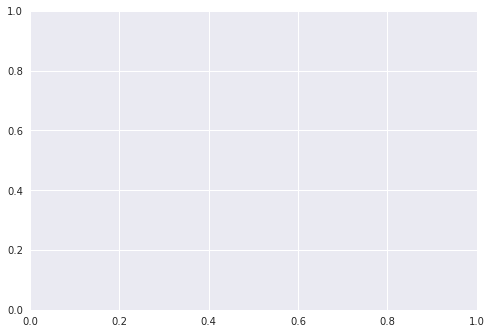

In [22]:
ax = pt.RainCloud(
    x = 'Condition', y = 0,
    data=modeldata['DeviceSpaceDist'],
    orient = 'h', width_viol = .8, width_box = .4
)
ax.set_xscale('log')

[None]

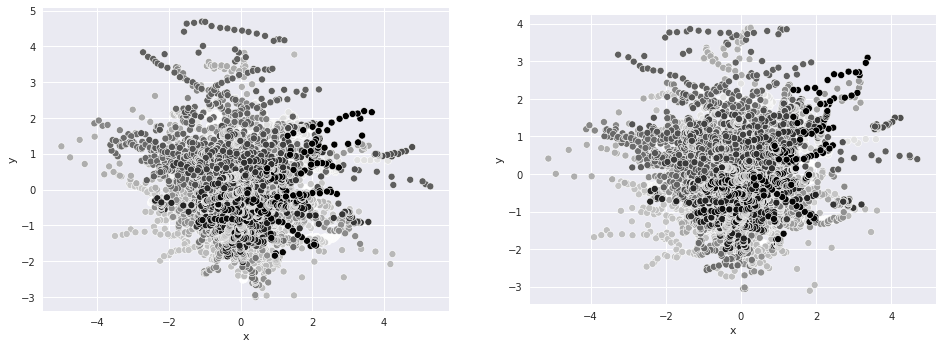

In [157]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
l = df.loc['004', '02', :, :][('LeftEye', 'SensorPos')].dropna()
r = df.loc['004', '02', :, :][('RightEye', 'SensorPos')].dropna()
sns.scatterplot( data=l, x='x', y='y', ax=ax[0], c=l.index.get_level_values(1))
sns.scatterplot( data=r, x='x', y='y', ax=ax[1], c=r.index.get_level_values(1))
ax[0].set(aspect='equal')
ax[1].set(aspect='equal')
# ax.set_title(cond_name)

In [13]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Setting standard filter requirements.
order = 6
fs = 30.0       
cutoff = 3.667  

b, a = butter_lowpass(cutoff, fs, order)

# Plotting the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()


fig, ax = plt.subplots(1,2, figsize=(16,8))
l = df.loc['004', '02', :, :][('LeftEye', 'SensorPos')].dropna()
r = df.loc['004', '02', :, :][('RightEye', 'SensorPos')].dropna()
sns.scatterplot( data=l, x='x', y='y', ax=ax[0], c=l.index.get_level_values(1))
sns.scatterplot( data=r, x='x', y='y', ax=ax[1], c=r.index.get_level_values(1))
ax[0].set(aspect='equal')
ax[1].set(aspect='equal')
# ax.set_title(cond_name)

# Creating the data for filteration
T = 5.0         # value taken in seconds
n = int(T * fs) # indicates total samples
t = np.linspace(0, T, n, endpoint=False)

data = np.sin(1.2*2*np.pi*t) + 1.5*np.cos(9*2*np.pi*t) + 0.5*np.sin(12.0*2*np.pi*t)

# Filtering and plotting
y = butter_lowpass_filter(data, cutoff, fs, order)

plt.subplot(2, 1, 2)
plt.plot(t, data, 'b-', label='data')
plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

,TimeStamp,TrackerTimeStamp,EyeIndex,Validity,Openness,PupilDiameter,PosInSensor,GazeOriginInEye,GazeDirectionNormInEye
0,637934834746303519,536310,LEFT,11111,1.0,4.54807,"(0.47802, 0.60086)","(34.51414, 0.11555, -29.62236)","(0.02580, -0.08002, 0.99644)"
1,637934834747913409,536468,LEFT,11111,1.0,4.46886,"(0.47294, 0.60039)","(34.62129, 0.35724, -30.47237)","(0.03436, -0.07773, 0.99637)"
2,637934834747973410,536485,LEFT,11111,1.0,4.46886,"(0.47294, 0.60039)","(34.62129, 0.35724, -30.47237)","(0.03436, -0.07773, 0.99637)"
3,637934834748033412,536485,LEFT,11111,1.0,4.46748,"(0.47290, 0.60039)","(34.62585, 0.36841, -30.51486)","(0.03360, -0.07756, 0.99641)"
4,637934834748093398,536485,LEFT,11111,1.0,4.46748,"(0.47290, 0.60039)","(34.62585, 0.36841, -30.51486)","(0.03360, -0.07756, 0.99641)"
...,...,...,...,...,...,...,...,...,...
6643,637934835766907929,638363,LEFT,11111,1.0,5.06110,"(0.52318, 0.58598)","(33.87666, 0.01509, -29.85228)","(-0.11548, 0.04846, 0.99211)"
6644,637934835767047912,638396,LEFT,11111,1.0,5.03038,"(0.52234, 0.58600)","(33.83641, 0.01395, -29.88414)","(-0.10201, 0.04990, 0.99353)"
6645,637934835767248166,638405,LEFT,11111,1.0,4.81848,"(0.52328, 0.58795)","(33.81828, -0.01390, -29.82259)","(-0.10222, 0.03844, 0.99400)"
6646,637934835767377922,638421,LEFT,11111,1.0,4.92600,"(0.52529, 0.58736)","(33.81601, -0.01271, -29.82834)","(-0.11452, 0.04338, 0.99246)"
